# Deep Learning with Transformer Method Development Code
This notebook contains the development portion of the deep learning model with transformer architecture, specifically using the DINOv2 model.

## Methodology
The final methodology is explained below:

### 1. Load and preprocess images
Images loaded from the dataset will be resized to 420x420 pixels, with a random horizontal flip with 50% probability and a random rotation of up to ±10 degrees. These images will be split into training and validation datasets, wherein the splits are 80-20 percent for the training and validation datasets respectively.

Note that an image size of 420x420px was used since the model requires the image size to be a multiple of 14. Using random horizontal flips and random rotations ensure that the model does not overfit.

### 2. Train and Evaluate the Model
The preprocessed data will then be parsed into the DINOv2 model, which acts as the transformer for our CNN model, whose features are then put through a final layer, which consists of a Dropout layer and a linear transformation layer. The model is evaluated through the accuracy, loss, and macro F1 score metrics.

Accuracy is used since we want to identify the proportion of correctly predicted images. That is, we want to accurately classify the images, which makes accuracy a good metric. Macro f1 score is also used as it evaluates the f1 score for each class. This makes it a good metric to evaluate the model's precision and recall even if there is an imbalance in the frequency of each class.


## Miscellaneous

In [1]:
import warnings
warnings.filterwarnings('ignore')

## Imports

In [ ]:
# Use if google colab
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import torch
from torch import nn, optim
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from copy import deepcopy
import os
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.metrics import accuracy_score, f1_score

## Constants

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# a list of all the possible classes for the potato leaves disease
classes = ["Bacteria", "Fungi", "Healthy", "Pest", "Phytopthora", "Virus"]

# path of where the train images are located
# img_dir = "/content/drive/MyDrive/potato_train" # if colab
img_dir = "../data/potato_train" # if local

# Batch Size
BATCH_SIZE = 8

# set seed
SEED_VAL = 42
torch.manual_seed(SEED_VAL)

# Image size has to be divisible by 14 (as per the model's requirements)
RESIZE_IMG = (420, 420)

In [4]:
device

device(type='cuda', index=0)

## Load and Preprocess Images

This section handles the loading and preprocessing of images that come from the data provided. Images are transformed/preprocessed through resizing, random horizontal flips, and then converted to tensors to simplify pipeline execution. The preprocessed data is then split into train and validation datasets for training and evaluation.

For preprocessing, the `train_transform` variable houses a pipeline that handles the preprocessing for each image that is passed through it.



In [5]:
train_transform = transforms.Compose([
    transforms.Resize(RESIZE_IMG),
    transforms.RandomHorizontalFlip(p=0.5), # Random flip with 50% probability
    transforms.RandomRotation(10),
    transforms.ToTensor(),
])

class PotatoLeafDisease(Dataset):
    def __init__(self, path_to_folder: str, transforms: transforms.Compose):
        # Get the path to each folder
        path_to_bac = os.path.join(path_to_folder, "Bacteria")
        path_to_fun = os.path.join(path_to_folder, "Fungi")
        path_to_heal = os.path.join(path_to_folder, "Healthy")
        path_to_pest = os.path.join(path_to_folder, "Pest")
        path_to_phy = os.path.join(path_to_folder, "Phytopthora")
        path_to_vir = os.path.join(path_to_folder, "Virus")

        # Get the list of all the files in the folder
        bac_files = os.listdir(path_to_bac)
        fun_files = os.listdir(path_to_fun)
        heal_files = os.listdir(path_to_heal)
        pest_files = os.listdir(path_to_pest)
        phy_files = os.listdir(path_to_phy)
        vir_files = os.listdir(path_to_vir)

        # Get full path to each file
        path_to_bac_files = [os.path.join(path_to_bac, file) for file in bac_files]
        path_to_fun_files = [os.path.join(path_to_fun, file) for file in fun_files]
        path_to_heal_files = [os.path.join(path_to_heal, file) for file in heal_files]
        path_to_pest_files = [os.path.join(path_to_pest, file) for file in pest_files]
        path_to_phy_files = [os.path.join(path_to_phy, file) for file in phy_files]
        path_to_vir_files = [os.path.join(path_to_vir, file) for file in vir_files]

        self.training_files = path_to_bac_files + path_to_fun_files + path_to_heal_files + path_to_pest_files + path_to_phy_files + path_to_vir_files

        self.bac_label: int = classes.index('Bacteria')
        self.fun_label: int = classes.index('Fungi')
        self.heal_label: int = classes.index('Healthy')
        self.pest_label: int = classes.index('Pest')
        self.phy_label: int = classes.index('Phytopthora')
        self.vir_label: int = classes.index('Virus')

        self.transform = transforms

    def __len__(self):
        return len(self.training_files)

    def __getitem__(self, idx: int) -> tuple[torch.Tensor, int]:
        path_to_image = self.training_files[idx]

        # Get the label of the image
        label = [classes.index(label) for label in classes if label in path_to_image][0]

        # Load the image
        image = Image.open(path_to_image)

        # Transform the image
        image = self.transform(image)

        return image, label

Number of Training Samples: 2165 Number of Test Samples 542
torch.Size([8, 3, 420, 420])
tensor([4, 5, 0, 3, 3, 5, 1, 0])


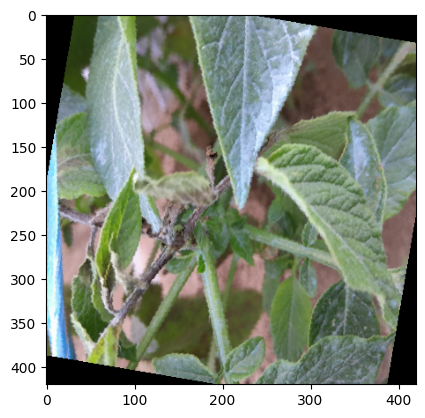

torch.Size([8, 3, 420, 420])
tensor([5, 3, 1, 3, 0, 1, 0, 1])


In [6]:
# Create the data
leaves_data = PotatoLeafDisease(path_to_folder=img_dir, transforms=train_transform)

# Split the data into train and validation
train_samples = int(0.8*len(leaves_data))
val_samples = len(leaves_data) - train_samples

print("Number of Training Samples:", train_samples, "Number of Test Samples", val_samples)

# Split the dataset
train_dataset, val_dataset = torch.utils.data.random_split(leaves_data, lengths=[train_samples, val_samples])

leaves_train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

leaves_val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)

# Printing
for images, labels in leaves_train_loader:
    print(images.shape)
    print(labels)
    plt.imshow(images[0].permute(1,2,0))
    plt.show()
    break

for images, labels in leaves_val_loader:
    print(images.shape)
    print(labels)
    break

## Transformer Architecture (DINOv2)
The DINOv2 model is used as the transformer for this method, as the architecture produced the best results compared to other architectures such as VGG-16, VGG-19, and EfficientNet. For this section, the model is simply loaded for use in the full architecture.

In [7]:
# Load the vits14 version of dinov2
dino_model = torch.hub.load('facebookresearch/dinov2', 'dinov2_vits14')
dino_model

Using cache found in C:\Users\Admin/.cache\torch\hub\facebookresearch_dinov2_main


DinoVisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 384, kernel_size=(14, 14), stride=(14, 14))
    (norm): Identity()
  )
  (blocks): ModuleList(
    (0-11): 12 x NestedTensorBlock(
      (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (attn): MemEffAttention(
        (qkv): Linear(in_features=384, out_features=1152, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=384, out_features=384, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): LayerScale()
      (drop_path1): Identity()
      (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=384, out_features=1536, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=1536, out_features=384, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
      (ls2): LayerScale()
      (drop_path2): Identity()
    )
  )
  (n

## Full Model

The full model is essentially the DINOv2 model as the transformer, with an extra dropout, ReLU, and linear transformation layer for further feature extraction. The model also sports an _ADAM_ optimizer, which allows the learning rates to be adjusted dynamically based on the gradients.

The `nn.Module` interface (provided by torchvision) is used to create the `DinoVisionTransformerClassifier` class, which houses the neural network implementation of the project. The interface that is concretized provides methods and attributes--such as the `to` and `train` methods, that simplify the entire training process to a few lines of code.


In [8]:
class DinoVisionTransformerClassifier(nn.Module):
    def __init__(self):
        super(DinoVisionTransformerClassifier, self).__init__()
        self.transformer = deepcopy(dino_model)
        self.classifier = nn.Sequential(nn.Dropout(0.7), nn.ReLU(), nn.Linear(in_features=384, out_features=len(classes), bias=True))

    def forward(self, x):
        x = self.transformer(x)
        x = self.transformer.norm(x)
        x = self.classifier(x)
        return x

model_train = DinoVisionTransformerClassifier()
model_train = model_train.to(device)
model_train = model_train.train()
model_train

DinoVisionTransformerClassifier(
  (transformer): DinoVisionTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 384, kernel_size=(14, 14), stride=(14, 14))
      (norm): Identity()
    )
    (blocks): ModuleList(
      (0-11): 12 x NestedTensorBlock(
        (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
        (attn): MemEffAttention(
          (qkv): Linear(in_features=384, out_features=1152, bias=True)
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=384, out_features=384, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (ls1): LayerScale()
        (drop_path1): Identity()
        (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=384, out_features=1536, bias=True)
          (act): GELU(approximate='none')
          (fc2): Linear(in_features=1536, out_features=384, bias=True)
          (drop): Dropout(p=0.0, in

In [9]:
# Total parameters and trainable parameters.
total_params = sum(p.numel() for p in model_train.parameters())
total_trainable_params = sum(p.numel() for p in model_train.parameters() if p.requires_grad)

print("Total Parameters:", total_params)
print("Total Trainable Parameters:", total_trainable_params)

Total Parameters: 22058886
Total Trainable Parameters: 22058886


#### Use cross entropy loss with Adam optimizer

In [10]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_train.parameters(), lr=1e-6)

## Training the Model

The model is trained on 50 epochs to ensure both accuracy and efficiency due to possible hardware constraints when training.

The mean train and validation epoch losses, macro F1 score, and the training and validation accuracy are shown for each epoch completed during the training runtime.

In [11]:
num_epochs = 50

In [12]:
train_losses, val_losses = [], []
train_acc, val_acc = [], []
train_f1, val_f1 = [], []

for epoch in tqdm(range(num_epochs)):
    batch_train_losses = []
    batch_val_losses = []
    all_train_preds = []
    all_train_labels = []
    all_val_preds = []
    all_val_labels = []

    for data in leaves_train_loader:
        # get the input batch and the labels
        batch_of_images, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # get outputs
        outputs = model_train(batch_of_images.to(device)).squeeze(dim=1)

        # compute the loss
        loss = criterion(outputs, labels.type(torch.LongTensor).to(device))

        # perform gradient descent
        loss.backward()
        optimizer.step()

        # validation
        train_preds = torch.argmax(outputs, dim=1)
        all_train_preds.extend(train_preds.cpu().numpy())
        all_train_labels.extend(labels.cpu().numpy())

        # loss for the batch
        batch_train_losses.append(loss.item())

    # validation with the val dataset
    for data in leaves_val_loader:
        model_train.eval()
        batch_of_images_val, labels_val = data

        with torch.no_grad():
            val_outputs = model_train(batch_of_images_val.to(device)).squeeze(dim=1)
            val_loss = criterion(val_outputs, labels_val.type(torch.LongTensor).to(device))

        val_preds = torch.argmax(val_outputs, dim=1)
        all_val_preds.extend(val_preds.cpu().numpy())
        all_val_labels.extend(labels_val.cpu().numpy())

        # loss for the batch
        batch_val_losses.append(val_loss.item())

    # get avg of the batch's train and validation loss
    train_losses.append(np.mean(batch_train_losses))
    val_losses.append(np.mean(batch_val_losses))

    # calculate accuracy
    train_acc_epoch = accuracy_score(all_train_labels, all_train_preds)
    val_acc_epoch = accuracy_score(all_val_labels, all_val_preds)

    train_acc.append(train_acc_epoch)
    val_acc.append(val_acc_epoch)

    # calculate f1
    train_f1_epoch = f1_score(all_train_labels, all_train_preds, average='macro')
    val_f1_epoch = f1_score(all_val_labels, all_val_preds, average='macro')

    train_f1.append(train_f1_epoch)
    val_f1.append(val_f1_epoch)

    print(f"\tMean train epoch loss: {train_losses[-1]}")
    print(f"\tMean val epoch loss: {val_losses[-1]}")
    print(f"\tTrain Accuracy: {train_acc[-1]} | Train Macro F1: {train_f1[-1]}")
    print(f"\tVal Accuracy: {val_acc[-1]} | Val Macro F1: {val_f1[-1]}")

print("Finished training!")

  2%|▏         | 1/50 [02:48<2:17:30, 168.38s/it]

	Mean train epoch loss: 2.1503185401103595
	Mean val epoch loss: 1.2599192042561138
	Train Accuracy: 0.3071593533487298 | Train Macro F1: 0.26613899189258977
	Val Accuracy: 0.488929889298893 | Val Macro F1: 0.3698405666926177


  4%|▍         | 2/50 [05:01<1:58:05, 147.62s/it]

	Mean train epoch loss: 0.9920819025637919
	Mean val epoch loss: 0.8695681892773685
	Train Accuracy: 0.6244803695150115 | Train Macro F1: 0.5277004363047691
	Val Accuracy: 0.6734317343173432 | Val Macro F1: 0.6307476121995266


  6%|▌         | 3/50 [07:14<1:50:20, 140.86s/it]

	Mean train epoch loss: 0.618665619942315
	Mean val epoch loss: 0.5644629742292797
	Train Accuracy: 0.8073903002309469 | Train Macro F1: 0.7974979568963493
	Val Accuracy: 0.8007380073800738 | Val Macro F1: 0.7913060599043336


  8%|▊         | 4/50 [09:29<1:46:10, 138.49s/it]

	Mean train epoch loss: 0.3933071685040789
	Mean val epoch loss: 0.43115066156229553
	Train Accuracy: 0.871593533487298 | Train Macro F1: 0.8679638972198204
	Val Accuracy: 0.8597785977859779 | Val Macro F1: 0.8586040569800953


 10%|█         | 5/50 [11:42<1:42:36, 136.81s/it]

	Mean train epoch loss: 0.30090773627299444
	Mean val epoch loss: 0.3816562669132562
	Train Accuracy: 0.9057736720554272 | Train Macro F1: 0.9025256407835799
	Val Accuracy: 0.8782287822878229 | Val Macro F1: 0.882454505298086


 12%|█▏        | 6/50 [13:56<1:39:37, 135.85s/it]

	Mean train epoch loss: 0.23590915635695536
	Mean val epoch loss: 0.335237601552816
	Train Accuracy: 0.9242494226327944 | Train Macro F1: 0.9200356282547535
	Val Accuracy: 0.8837638376383764 | Val Macro F1: 0.8838135955023522


 14%|█▍        | 7/50 [16:09<1:36:34, 134.76s/it]

	Mean train epoch loss: 0.1780581986720629
	Mean val epoch loss: 0.29443471914376407
	Train Accuracy: 0.9468822170900693 | Train Macro F1: 0.9434775922060705
	Val Accuracy: 0.9003690036900369 | Val Macro F1: 0.8974575665405972


 16%|█▌        | 8/50 [18:22<1:33:54, 134.16s/it]

	Mean train epoch loss: 0.1601437796628948
	Mean val epoch loss: 0.30408132451531644
	Train Accuracy: 0.9496535796766744 | Train Macro F1: 0.9469092369822917
	Val Accuracy: 0.9040590405904059 | Val Macro F1: 0.9002990710021361


 18%|█▊        | 9/50 [20:35<1:31:23, 133.75s/it]

	Mean train epoch loss: 0.11120528634981255
	Mean val epoch loss: 0.35596017820267556
	Train Accuracy: 0.9695150115473441 | Train Macro F1: 0.9670228545408658
	Val Accuracy: 0.8782287822878229 | Val Macro F1: 0.8747353822359095


 20%|██        | 10/50 [22:48<1:29:02, 133.56s/it]

	Mean train epoch loss: 0.09326142345201155
	Mean val epoch loss: 0.3052190835861599
	Train Accuracy: 0.9773672055427252 | Train Macro F1: 0.9750172991946663
	Val Accuracy: 0.8911439114391144 | Val Macro F1: 0.890329166787959


 22%|██▏       | 11/50 [25:01<1:26:42, 133.41s/it]

	Mean train epoch loss: 0.08248974294298607
	Mean val epoch loss: 0.28739976528210237
	Train Accuracy: 0.979676674364896 | Train Macro F1: 0.978850247716779
	Val Accuracy: 0.8985239852398524 | Val Macro F1: 0.8961350824821469


 24%|██▍       | 12/50 [27:14<1:24:20, 133.17s/it]

	Mean train epoch loss: 0.07114695792938702
	Mean val epoch loss: 0.29641606858657565
	Train Accuracy: 0.9838337182448037 | Train Macro F1: 0.9832902523597916
	Val Accuracy: 0.9040590405904059 | Val Macro F1: 0.9008473888594378


 26%|██▌       | 13/50 [29:26<1:22:04, 133.08s/it]

	Mean train epoch loss: 0.06258402878978733
	Mean val epoch loss: 0.2709261881023207
	Train Accuracy: 0.9861431870669746 | Train Macro F1: 0.9838278791227597
	Val Accuracy: 0.9077490774907749 | Val Macro F1: 0.9054403820112595


 28%|██▊       | 14/50 [31:39<1:19:49, 133.03s/it]

	Mean train epoch loss: 0.04362460230159267
	Mean val epoch loss: 0.34288143071085764
	Train Accuracy: 0.9916859122401848 | Train Macro F1: 0.9901816011458887
	Val Accuracy: 0.8929889298892989 | Val Macro F1: 0.8877185463030649


 30%|███       | 15/50 [33:52<1:17:32, 132.94s/it]

	Mean train epoch loss: 0.03949834410843484
	Mean val epoch loss: 0.34526593904079433
	Train Accuracy: 0.9921478060046189 | Train Macro F1: 0.9917350941459501
	Val Accuracy: 0.8892988929889298 | Val Macro F1: 0.8869927418938303


 32%|███▏      | 16/50 [36:05<1:15:20, 132.95s/it]

	Mean train epoch loss: 0.04172241917082772
	Mean val epoch loss: 0.31622208090266213
	Train Accuracy: 0.9893764434180139 | Train Macro F1: 0.988469469794557
	Val Accuracy: 0.9040590405904059 | Val Macro F1: 0.9013351612360472


 34%|███▍      | 17/50 [38:18<1:13:04, 132.87s/it]

	Mean train epoch loss: 0.03329196295484461
	Mean val epoch loss: 0.2833765650267357
	Train Accuracy: 0.9958429561200923 | Train Macro F1: 0.9962094863367934
	Val Accuracy: 0.922509225092251 | Val Macro F1: 0.9226379914673432


 36%|███▌      | 18/50 [40:31<1:10:53, 132.92s/it]

	Mean train epoch loss: 0.030927086837728924
	Mean val epoch loss: 0.2919248536910506
	Train Accuracy: 0.9935334872979215 | Train Macro F1: 0.993093662755634
	Val Accuracy: 0.9243542435424354 | Val Macro F1: 0.9234019608811451


 38%|███▊      | 19/50 [42:44<1:08:42, 133.00s/it]

	Mean train epoch loss: 0.017282836226406216
	Mean val epoch loss: 0.29170531321056736
	Train Accuracy: 0.9981524249422633 | Train Macro F1: 0.9984963179592189
	Val Accuracy: 0.9114391143911439 | Val Macro F1: 0.9045821984696314


 40%|████      | 20/50 [44:57<1:06:26, 132.88s/it]

	Mean train epoch loss: 0.02765930531313643
	Mean val epoch loss: 0.34277834518990646
	Train Accuracy: 0.9930715935334873 | Train Macro F1: 0.991754636340926
	Val Accuracy: 0.9040590405904059 | Val Macro F1: 0.8994035629914977


 42%|████▏     | 21/50 [47:09<1:04:13, 132.88s/it]

	Mean train epoch loss: 0.02553975646086793
	Mean val epoch loss: 0.2935255283202209
	Train Accuracy: 0.994919168591224 | Train Macro F1: 0.994520148894872
	Val Accuracy: 0.9206642066420664 | Val Macro F1: 0.9206393769388127


 44%|████▍     | 22/50 [49:22<1:01:58, 132.82s/it]

	Mean train epoch loss: 0.03170503232206263
	Mean val epoch loss: 0.34034372765317505
	Train Accuracy: 0.9903002309468822 | Train Macro F1: 0.989328234111277
	Val Accuracy: 0.9059040590405905 | Val Macro F1: 0.8981482493373821


 46%|████▌     | 23/50 [51:35<59:46, 132.82s/it]  

	Mean train epoch loss: 0.018488094065427726
	Mean val epoch loss: 0.3651462359874345
	Train Accuracy: 0.9958429561200923 | Train Macro F1: 0.9955531008829865
	Val Accuracy: 0.8966789667896679 | Val Macro F1: 0.8879234477043413


 48%|████▊     | 24/50 [53:48<57:37, 132.99s/it]

	Mean train epoch loss: 0.010722412351141701
	Mean val epoch loss: 0.3394705782531459
	Train Accuracy: 0.9981524249422633 | Train Macro F1: 0.997313800417027
	Val Accuracy: 0.8985239852398524 | Val Macro F1: 0.8985848140202054


 50%|█████     | 25/50 [56:01<55:23, 132.95s/it]

	Mean train epoch loss: 0.023548629934658085
	Mean val epoch loss: 0.3134402930573903
	Train Accuracy: 0.9921478060046189 | Train Macro F1: 0.9921823512882245
	Val Accuracy: 0.9206642066420664 | Val Macro F1: 0.9223903781965433


 52%|█████▏    | 26/50 [58:14<53:11, 132.96s/it]

	Mean train epoch loss: 0.025399184559503695
	Mean val epoch loss: 0.3385894883009742
	Train Accuracy: 0.9926096997690531 | Train Macro F1: 0.9924412376888361
	Val Accuracy: 0.9114391143911439 | Val Macro F1: 0.9079599739493007


 54%|█████▍    | 27/50 [1:00:27<50:58, 132.99s/it]

	Mean train epoch loss: 0.016312318769622098
	Mean val epoch loss: 0.36819050061389774
	Train Accuracy: 0.9963048498845266 | Train Macro F1: 0.9959082751261712
	Val Accuracy: 0.8966789667896679 | Val Macro F1: 0.8772223144520809


 56%|█████▌    | 28/50 [1:02:40<48:44, 132.91s/it]

	Mean train epoch loss: 0.023969561040721062
	Mean val epoch loss: 0.32531413274495313
	Train Accuracy: 0.994919168591224 | Train Macro F1: 0.9947324308405295
	Val Accuracy: 0.9132841328413284 | Val Macro F1: 0.9065027845415267


 58%|█████▊    | 29/50 [1:04:53<46:32, 133.00s/it]

	Mean train epoch loss: 0.02177284551548988
	Mean val epoch loss: 0.31220585884362023
	Train Accuracy: 0.9935334872979215 | Train Macro F1: 0.993546152778021
	Val Accuracy: 0.9114391143911439 | Val Macro F1: 0.9103002760943211


 60%|██████    | 30/50 [1:07:06<44:20, 133.04s/it]

	Mean train epoch loss: 0.01823617298509565
	Mean val epoch loss: 0.2592523109111319
	Train Accuracy: 0.9953810623556582 | Train Macro F1: 0.9955251312086603
	Val Accuracy: 0.922509225092251 | Val Macro F1: 0.921422320093895


 62%|██████▏   | 31/50 [1:09:19<42:05, 132.95s/it]

	Mean train epoch loss: 0.01914718715898002
	Mean val epoch loss: 0.3359070025702856
	Train Accuracy: 0.9944572748267898 | Train Macro F1: 0.9943444000669066
	Val Accuracy: 0.9040590405904059 | Val Macro F1: 0.9014657724430138


 64%|██████▍   | 32/50 [1:11:32<39:53, 132.99s/it]

	Mean train epoch loss: 0.014685954316733989
	Mean val epoch loss: 0.29979943558881883
	Train Accuracy: 0.994919168591224 | Train Macro F1: 0.9952462772722631
	Val Accuracy: 0.922509225092251 | Val Macro F1: 0.9161207255739084


 66%|██████▌   | 33/50 [1:13:45<37:40, 133.00s/it]

	Mean train epoch loss: 0.015571259730828435
	Mean val epoch loss: 0.3197186690248439
	Train Accuracy: 0.9953810623556582 | Train Macro F1: 0.9946710052711092
	Val Accuracy: 0.9077490774907749 | Val Macro F1: 0.9043052575032934


 68%|██████▊   | 34/50 [1:15:58<35:26, 132.93s/it]

	Mean train epoch loss: 0.00911574192598378
	Mean val epoch loss: 0.4122089334191782
	Train Accuracy: 0.997228637413395 | Train Macro F1: 0.9974638717477472
	Val Accuracy: 0.8966789667896679 | Val Macro F1: 0.8938214767714122


 70%|███████   | 35/50 [1:18:11<33:14, 132.96s/it]

	Mean train epoch loss: 0.021736749438646275
	Mean val epoch loss: 0.3671346852116746
	Train Accuracy: 0.9921478060046189 | Train Macro F1: 0.9927215802141106
	Val Accuracy: 0.9132841328413284 | Val Macro F1: 0.9149423552677147


 72%|███████▏  | 36/50 [1:20:24<31:01, 132.94s/it]

	Mean train epoch loss: 0.0181445595292835
	Mean val epoch loss: 0.348736912906615
	Train Accuracy: 0.9939953810623556 | Train Macro F1: 0.9932976251819317
	Val Accuracy: 0.9114391143911439 | Val Macro F1: 0.9043548390549723


 74%|███████▍  | 37/50 [1:22:37<28:47, 132.91s/it]

	Mean train epoch loss: 0.012687900663367249
	Mean val epoch loss: 0.3559932462470469
	Train Accuracy: 0.9963048498845266 | Train Macro F1: 0.9963000474353928
	Val Accuracy: 0.922509225092251 | Val Macro F1: 0.920619194429019


 76%|███████▌  | 38/50 [1:24:50<26:35, 132.98s/it]

	Mean train epoch loss: 0.012785666799636702
	Mean val epoch loss: 0.3223687505913618
	Train Accuracy: 0.9967667436489608 | Train Macro F1: 0.9966530217007751
	Val Accuracy: 0.9022140221402214 | Val Macro F1: 0.9004169675496517


 78%|███████▊  | 39/50 [1:27:02<24:21, 132.90s/it]

	Mean train epoch loss: 0.011778271216873382
	Mean val epoch loss: 0.3622831129811375
	Train Accuracy: 0.9967667436489608 | Train Macro F1: 0.9962152894379361
	Val Accuracy: 0.9095940959409594 | Val Macro F1: 0.904413287120054


 80%|████████  | 40/50 [1:29:15<22:08, 132.89s/it]

	Mean train epoch loss: 0.010620359109439268
	Mean val epoch loss: 0.37964468411048397
	Train Accuracy: 0.9963048498845266 | Train Macro F1: 0.9967121837965159
	Val Accuracy: 0.9077490774907749 | Val Macro F1: 0.9027698916737066


 82%|████████▏ | 41/50 [1:31:28<19:56, 132.90s/it]

	Mean train epoch loss: 0.022184385779864462
	Mean val epoch loss: 0.3522256181535982
	Train Accuracy: 0.9935334872979215 | Train Macro F1: 0.9931377348952805
	Val Accuracy: 0.9114391143911439 | Val Macro F1: 0.9087130080623367


 84%|████████▍ | 42/50 [1:33:41<17:43, 132.91s/it]

	Mean train epoch loss: 0.014020420519619617
	Mean val epoch loss: 0.3259959005021408
	Train Accuracy: 0.994919168591224 | Train Macro F1: 0.993984909852244
	Val Accuracy: 0.9059040590405905 | Val Macro F1: 0.9042393312683554


 86%|████████▌ | 43/50 [1:35:54<15:30, 132.93s/it]

	Mean train epoch loss: 0.010984386925981209
	Mean val epoch loss: 0.41550243794592784
	Train Accuracy: 0.9963048498845266 | Train Macro F1: 0.9961197544402655
	Val Accuracy: 0.9003690036900369 | Val Macro F1: 0.8940094586722503


 88%|████████▊ | 44/50 [1:38:07<13:17, 132.96s/it]

	Mean train epoch loss: 0.014046674829744905
	Mean val epoch loss: 0.3446908313447185
	Train Accuracy: 0.9963048498845266 | Train Macro F1: 0.9963985282953435
	Val Accuracy: 0.8985239852398524 | Val Macro F1: 0.8907030002370875


 90%|█████████ | 45/50 [1:40:20<11:04, 132.90s/it]

	Mean train epoch loss: 0.009065440991237017
	Mean val epoch loss: 0.3904751426410204
	Train Accuracy: 0.9967667436489608 | Train Macro F1: 0.9966530217007751
	Val Accuracy: 0.9040590405904059 | Val Macro F1: 0.8995440409929722


 92%|█████████▏| 46/50 [1:42:33<08:51, 132.94s/it]

	Mean train epoch loss: 0.005585625100682397
	Mean val epoch loss: 0.3942034205833539
	Train Accuracy: 0.9976905311778291 | Train Macro F1: 0.9977468316724644
	Val Accuracy: 0.9169741697416974 | Val Macro F1: 0.9174217287179401


 94%|█████████▍| 47/50 [1:44:46<06:38, 132.88s/it]

	Mean train epoch loss: 0.008865803179149197
	Mean val epoch loss: 0.3865347453102004
	Train Accuracy: 0.9967667436489608 | Train Macro F1: 0.9966551646066395
	Val Accuracy: 0.9114391143911439 | Val Macro F1: 0.9102955176993127


 96%|█████████▌| 48/50 [1:46:59<04:25, 132.99s/it]

	Mean train epoch loss: 0.0058185549332243494
	Mean val epoch loss: 0.3463774869164541
	Train Accuracy: 0.9976905311778291 | Train Macro F1: 0.9977452585073063
	Val Accuracy: 0.9059040590405905 | Val Macro F1: 0.9023293759671321


 98%|█████████▊| 49/50 [1:49:12<02:13, 133.08s/it]

	Mean train epoch loss: 0.010235895380821093
	Mean val epoch loss: 0.47316603753236397
	Train Accuracy: 0.9967667436489608 | Train Macro F1: 0.9970582690098856
	Val Accuracy: 0.8856088560885609 | Val Macro F1: 0.8860514797883341


100%|██████████| 50/50 [1:51:25<00:00, 133.71s/it]

	Mean train epoch loss: 0.03604452364143273
	Mean val epoch loss: 0.312680044248255
	Train Accuracy: 0.9856812933025404 | Train Macro F1: 0.9862904086365063
	Val Accuracy: 0.9243542435424354 | Val Macro F1: 0.922724262168506
Finished training!


## Results

Graphs for both train/validation accuracy and loss.

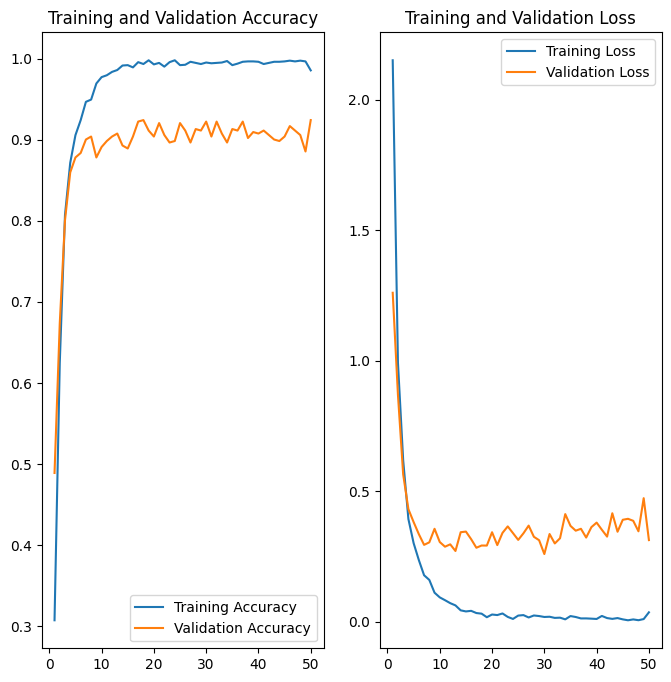

In [13]:
plt.figure(figsize=(8, 8))
epochs_range = range(1,num_epochs+1)
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_losses, label='Training Loss')
plt.plot(epochs_range, val_losses, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Saving the Model

In [14]:
torch.save(model_train.state_dict(), Path("../models/dino_model_state_dict.pth"))
torch.save(model_train, Path("../models/dino_model_final.pth"))